##### Copyright 2019 The TensorFlow Authors.

In [ ]:
#@title Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
# https://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

<table class="tfo-notebook-buttons" align="left">
  <td>
    <a target="_blank" href="https://colab.research.google.com/github/tensorflow/examples/blob/master/courses/udacity_intro_to_tensorflow_for_deep_learning/l07c01_saving_and_loading_models.ipynb"><img src="https://www.tensorflow.org/images/colab_logo_32px.png" />Run in Google Colab</a>
  </td>
  <td>
    <a target="_blank" href="https://github.com/tensorflow/examples/blob/master/courses/udacity_intro_to_tensorflow_for_deep_learning/l07c01_saving_and_loading_models.ipynb"><img src="https://www.tensorflow.org/images/GitHub-Mark-32px.png" />View source on GitHub</a>
  </td>
</table>

＃モデルの保存と読み込み

このチュートリアルでは、トレーニング済みのモデルを取得して保存し、それをロードしてトレーニングを継続するか、それを使用して推論を実行する方法を学習します。 特に、前のレッスンで行ったように、転移学習を使用して分類器を訓練し、猫と犬の画像を分類します。 次に、トレーニング済みのモデルをHDF5ファイルとして保存します。これはKerasが使用する形式です。 次に、このモデルをロードし、それを使用して予測を実行してから、モデルのトレーニングを続けます。 最後に、トレーニングしたモデルをTensorFlow SavedModelとして保存し、ローカルディスクにダウンロードして、後で異なるプラットフォームでの展開に使用できるようにします。

## Concepts that will be covered in this Colab

1. Keras用にHDF5形式でモデルを保存する
2. モデルをTensorFlow SavedModel形式で保存する
3. モデルの読み込み
4. モデルをローカルディスクにダウンロードする

このColabを開始する前に、上のメニューから[ランタイム->すべてのランタイムをリセット...]を選択して、Colab環境をリセットする必要があります。

# Imports

このColabでは、TensorFlow 2.0ベータ版を使用します。

In [ ]:
# try:
#   # Use the %tensorflow_version magic if in colab.
#   %tensorflow_version 2.x
# except Exception:
#   !pip install -q -U "tensorflow-gpu==2.0.0rc0" 

In [ ]:
# !pip install -q -U tensorflow_hub
# !pip install -q -U tensorflow_datasets

以前見たいくつかの通常のインポート。

In [ ]:
#from __future__ import absolute_import, division, print_function, unicode_literals

In [4]:
import time
import numpy as np
import matplotlib.pylab as plt

import tensorflow as tf
import tensorflow_hub as hub
import tensorflow_datasets as tfds
tfds.disable_progress_bar()

from tensorflow.keras import layers

# Part 1: Load the Cats vs. Dogs Dataset

TensorFlowデータセットを使用して、Dogs vs Catsデータセットをロードします。

In [5]:
splits = tfds.Split.ALL.subsplit(weighted=(80, 20))

splits, info = tfds.load('cats_vs_dogs', with_info=True, as_supervised=True, split = splits)

(train_examples, validation_examples) = splits

Dogs vs. Catsデータセットの画像は、すべて同じサイズではありません。 そのため、すべての画像をMobileNetが期待する解像度に再フォーマットする必要があります（224、224）

In [6]:
def format_image(image, label):
  # `hub` image modules exepct their data normalized to the [0,1] range.
  image = tf.image.resize(image, (IMAGE_RES, IMAGE_RES))/255.0
  return  image, label

num_examples = info.splits['train'].num_examples

BATCH_SIZE = 32
IMAGE_RES = 224

train_batches      = train_examples.cache().shuffle(num_examples//4).map(format_image).batch(BATCH_SIZE).prefetch(1)
validation_batches = validation_examples.cache().map(format_image).batch(BATCH_SIZE).prefetch(1)

# Part 2: Transfer Learning with TensorFlow Hub

TensorFlow Hubを使用して、転移学習を行います。

In [7]:
URL = "https://tfhub.dev/google/tf2-preview/mobilenet_v2/feature_vector/4"
feature_extractor = hub.KerasLayer(URL,
                                   input_shape=(IMAGE_RES, IMAGE_RES,3))

特徴抽出レイヤーの変数をフリーズして、トレーニングが最終分類レイヤーのみを変更するようにします。

In [8]:
feature_extractor.trainable = False

## Attach a classification head

ここで、ハブ層を「tf.keras.Sequential」モデルでラップし、新しい分類層を追加します。

In [9]:
model = tf.keras.Sequential([
  feature_extractor,
  layers.Dense(2, activation='softmax')
])

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
keras_layer (KerasLayer)     (None, 1280)              2257984   
_________________________________________________________________
dense (Dense)                (None, 2)                 2562      
Total params: 2,260,546
Trainable params: 2,562
Non-trainable params: 2,257,984
_________________________________________________________________


## Train the model

最初に `compile`を呼び出し、次に` fit`を呼び出すことにより、他のモデルと同様にこのモデルをトレーニングします。

In [10]:
model.compile(
  optimizer='adam', 
  loss=tf.losses.SparseCategoricalCrossentropy(),
  metrics=['accuracy'])

EPOCHS = 3
history = model.fit(train_batches,
                    epochs=EPOCHS,
                    validation_data=validation_batches)

Epoch 1/3
582/582 [==============================] - 37s 63ms/step - loss: 0.0500 - accuracy: 0.9838 - val_loss: 0.0000e+00 - val_accuracy: 0.0000e+00
Epoch 2/3
582/582 [==============================] - 37s 64ms/step - loss: 0.0292 - accuracy: 0.9895 - val_loss: 0.0301 - val_accuracy: 0.9886
Epoch 3/3
582/582 [==============================] - 18s 31ms/step - loss: 0.0244 - accuracy: 0.9922 - val_loss: 0.0293 - val_accuracy: 0.9888


## Check the predictions

クラス名の順序付きリストを取得します。

In [11]:
class_names = np.array(info.features['label'].names)
class_names

array(['cat', 'dog'], dtype='<U3')

モデルを介して画像バッチを実行し、インデックスをクラス名に変換します。

In [12]:
image_batch, label_batch = next(iter(train_batches.take(1)))
image_batch = image_batch.numpy()
label_batch = label_batch.numpy()

predicted_batch = model.predict(image_batch)
predicted_batch = tf.squeeze(predicted_batch).numpy()
predicted_ids = np.argmax(predicted_batch, axis=-1)
predicted_class_names = class_names[predicted_ids]
predicted_class_names

array(['cat', 'cat', 'cat', 'dog', 'dog', 'dog', 'dog', 'cat', 'cat',
       'cat', 'cat', 'dog', 'cat', 'cat', 'dog', 'cat', 'cat', 'cat',
       'cat', 'dog', 'dog', 'dog', 'dog', 'dog', 'dog', 'cat', 'cat',
       'dog', 'dog', 'dog', 'dog', 'cat'], dtype='<U3')

真のラベルと予測ラベルを見てみましょう。

In [13]:
print("Labels: ", label_batch)
print("Predicted labels: ", predicted_ids)

Labels:  [0 0 0 1 1 1 1 0 0 0 0 1 0 0 1 0 0 0 0 1 1 1 1 1 1 0 0 1 1 1 1 0]
Predicted labels:  [0 0 0 1 1 1 1 0 0 0 0 1 0 0 1 0 0 0 0 1 1 1 1 1 1 0 0 1 1 1 1 0]


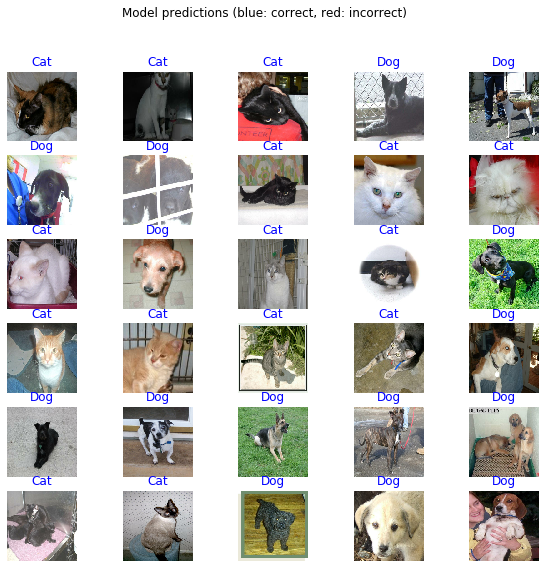

In [14]:
plt.figure(figsize=(10,9))
for n in range(30):
  plt.subplot(6,5,n+1)
  plt.imshow(image_batch[n])
  color = "blue" if predicted_ids[n] == label_batch[n] else "red"
  plt.title(predicted_class_names[n].title(), color=color)
  plt.axis('off')
_ = plt.suptitle("Model predictions (blue: correct, red: incorrect)")

# Part 3: Save as Keras `.h5` model

モデルのトレーニングが完了したので、Kerasが使用する形式であるHDF5ファイルとして保存できます。 HDF5ファイルの拡張子は「.h5」になり、その名前は現在のタイムスタンプに対応します。

In [15]:
t = time.time()

export_path_keras = "./{}.h5".format(int(t))
print(export_path_keras)

model.save(export_path_keras)

./1575986748.h5


In [ ]:
!ls

モデルを作成したコードにアクセスできなくなった場合でも、後でこのファイルから同じモデルを再作成できます。

このファイルには以下が含まれます。

- モデルのアーキテクチャ
- モデルの重み値（トレーニング中に学習された）
- もしあれば、モデルのトレーニング設定（ `compile`に渡したもの）
- オプティマイザーとその状態（存在する場合）（これにより、中断したところからトレーニングを再開できます）


# Part 4:  Load the Keras `.h5` Model

保存したモデルを「reloaded」という新しいモデルにロードします。 ファイルパスと `custom_objects`パラメーターを提供する必要があります。 このパラメーターは、転送学習に使用した「feature_extractor」から「hub.KerasLayer」を読み込む方法をkerasに指示します。.

In [16]:
reloaded = tf.keras.models.load_model(
  export_path_keras, 
  # `custom_objects` tells keras how to load a `hub.KerasLayer`
  custom_objects={'KerasLayer': hub.KerasLayer})

reloaded.summary()

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
keras_layer (KerasLayer)     (None, 1280)              2257984   
_________________________________________________________________
dense (Dense)                (None, 2)                 2562      
Total params: 2,260,546
Trainable params: 2,562
Non-trainable params: 2,257,984
_________________________________________________________________


リロードされたモデルと前のモデルが同じ結果を与えることを確認できます

In [17]:
result_batch = model.predict(image_batch)
reloaded_result_batch = reloaded.predict(image_batch)

出力の差はゼロでなければなりません：

In [18]:
(abs(result_batch - reloaded_result_batch)).max()

0.0

ご覧のとおり、結果は0.0であり、これは両方のモデルが同じ画像バッチで同じ予測を行ったことを示します。

# Keep Training

予測に加えて、「リロード」モデルを取得してトレーニングを続けることもできます。 これを行うには、 `.fit`メソッドを使用して、いつものように` realoaded`をトレーニングするだけです。

In [19]:
EPOCHS = 3
history = reloaded.fit(train_batches,
                    epochs=EPOCHS,
                    validation_data=validation_batches)

Epoch 1/3
582/582 [==============================] - 33s 57ms/step - loss: 0.0225 - accuracy: 0.9922 - val_loss: 0.0000e+00 - val_accuracy: 0.0000e+00
Epoch 2/3
582/582 [==============================] - 18s 31ms/step - loss: 0.0184 - accuracy: 0.9948 - val_loss: 0.0345 - val_accuracy: 0.9888
Epoch 3/3
582/582 [==============================] - 18s 31ms/step - loss: 0.0187 - accuracy: 0.9938 - val_loss: 0.0341 - val_accuracy: 0.9890


# Part 5: Export as SavedModel



モデル全体をTensorFlow SavedModel形式にエクスポートすることもできます。 SavedModelはTensorflowオブジェクト用のスタンドアロンのシリアル化形式であり、TensorFlowサービスとPython以外のTensorFlow実装でサポートされています。 SavedModelには、重みと計算を含む完全なTensorFlowプログラムが含まれています。元のモデル構築コードを実行する必要がないため、共有またはデプロイに役立ちます（TFLite、TensorFlow.js、TensorFlow Serving、またはTFHubを使用）。

作成されたSavedModelファイルには以下が含まれます。

* モデルの重みを含むTensorFlowチェックポイント。
* 基礎となるTensorflowグラフを含むSavedModelプロトタイプ。予測（サービング）、トレーニング、および評価のために、個別のグラフが保存されます。モデルが以前にコンパイルされていない場合、推論グラフのみがエクスポートされます。
* モデルのアーキテクチャ設定（利用可能な場合）。


元の「モデル」をTensorFlow SavedModelとして保存しましょう。これを行うには、 `tf.saved_model.save（）`関数を使用します。この関数は、保存するモデルと、モデルを保存するフォルダーへのパスを受け取ります。

この関数は、 `assets`フォルダー、` variables`フォルダー、および `saved_model.pb`ファイルを見つけるフォルダーを作成します。

In [20]:
t = time.time()

export_path_sm = "./{}".format(int(t))
print(export_path_sm)

tf.saved_model.save(model, export_path_sm)

./1575986862
Instructions for updating:
If using Keras pass *_constraint arguments to layers.


Instructions for updating:
If using Keras pass *_constraint arguments to layers.


NotFoundError: Failed to create a directory: ./1575986862\variables; No such file or directory

In [ ]:
!ls {export_path_sm}

# Part 6: Load SavedModel

次に、SavedModelをロードして、予測を行うために使用します。 SavedModelsをロードするには、 `tf.saved_model.load（）`関数を使用します。 `tf.saved_model.load`によって返されるオブジェクトは、それを作成したコードから完全に独立しています。

In [ ]:
reloaded_sm = tf.saved_model.load(export_path_sm)

次に、 `reloaded_sm`（リロードされたSavedModel）を使用して、画像のバッチを予測します。

In [ ]:
reload_sm_result_batch = reloaded_sm(image_batch, training=False).numpy()

リロードされたSavedModelと以前のモデルが同じ結果を与えることを確認できます。

In [ ]:
(abs(result_batch - reload_sm_result_batch)).max()

ご覧のとおり、結果は0.0であり、これは両方のモデルが同じ画像バッチで同じ予測を行ったことを示します。

# Part 7: Loading the SavedModel as a Keras Model

`tf.saved_model.load`によって返されるオブジェクトはKerasオブジェクトではありません（つまり、` .fit`、 `.predict`、` .summary`などのメソッドはありません）。 したがって、 `reloaded_sm`モデルを単純に取得して、` .fit`を実行してトレーニングを続けることはできません。 Tensorflow SavedModel形式から完全なkerasモデルを取得できるようにするには、 `tf.keras.models.load_model`関数を使用する必要があります。 この関数は、SavedModelを含むフォルダーへのパスを渡すことを除いて、以前と同じように機能します。

In [ ]:
t = time.time()

export_path_sm = "./{}".format(int(t))
print(export_path_sm)
tf.saved_model.save(model, export_path_sm)

In [ ]:
reload_sm_keras = tf.keras.models.load_model(
  export_path_sm,
  custom_objects={'KerasLayer': hub.KerasLayer})

reload_sm_keras.summary()

次に、 `reloaded_sm）keras`（SavedModelからKerasモデルをリロード）を使用して、画像のバッチを予測します。

In [ ]:
result_batch = model.predict(image_batch)
reload_sm_keras_result_batch = reload_sm_keras.predict(image_batch)

リロードされたKerasモデルと以前のモデルが同じ結果を与えることを確認できます。

In [ ]:
(abs(result_batch - reload_sm_keras_result_batch)).max()

# Part 8:  Download your model

zipファイルを作成して、保存したモデルをローカルディスクにダウンロードできます。 すべてのサブフォルダーを圧縮するには、 `-r`（再帰）オプションを使用します。

In [ ]:
!zip -r model.zip {export_path_sm}

zipファイルは現在の作業ディレクトリに保存されます。 次のコマンドを実行すると、現在の作業ディレクトリが何であるかを確認できます。

In [ ]:
!ls

Once the file is zipped, you can download  it to your local disk. 

In [ ]:
try:
  from google.colab import files
  files.download('./model.zip')
except ImportError:
  pass

`files.download`コマンドは現在の作業ディレクトリでファイルを検索します。 ダウンロードするファイルが現在の作業ディレクトリ以外のディレクトリにある場合は、ファイルが置かれているディレクトリへのパスを含める必要があります。